In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Static Variables

In [2]:
line = "46A"

### Extracting Data

In [3]:
df = pd.read_csv("bus_data/clean_data2/" + line + ".csv", low_memory=False, header=None)
df.columns = ["Timestamp", "LineID", "JourneyPatternID", "TimeFrame", 
              "VehicleJourneyID", "Lon", "Lat", "VehicleID", "StopID", 
              "AtStop", "HumanTime", "Day", "Hour", "JourneyGroup", "Runtime"]

#convert StopID to string

df['StopID'] = df['StopID'].astype('str')


df.shape

(607675, 15)

In [4]:
schedule = pd.read_csv("bus_data/dublinbus_scheduledData2013csv.csv", low_memory=False, encoding="ISO-8859-1")


In [5]:
# Dropping null values - some in our dataframe are marked as 'null' (string) for some reason?
schedule = schedule.dropna()
df = df[df.StopID != 'null']

### Exploring schedule

In [6]:
df.dtypes

Timestamp             int64
LineID               object
JourneyPatternID      int64
TimeFrame            object
VehicleJourneyID      int64
Lon                 float64
Lat                 float64
VehicleID             int64
StopID               object
AtStop                int64
HumanTime            object
Day                   int64
Hour                  int64
JourneyGroup         object
Runtime               int64
dtype: object

In [7]:
# Extracting StopID from stop_id

def get_stop(string):
    var = string[-4:]
    return var

schedule["StopID"] = schedule['stop_id'].apply(lambda x: get_stop(x))

In [8]:
# Extracting LineID from trip_id

schedule["LineID"] = schedule["trip_id"].str.extract('\-(.*?)\-')

/Users/danieljordan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  app.launch_new_instance()


In [9]:
# Convert StopIDs back to int

df['StopID'] = df['StopID'].astype('int64')
schedule['StopID'] = schedule['StopID'].astype('int64')

In [10]:
# Extracting direction from trip_id

def get_direction(string):
    var = string[-1:]
    return var

schedule["Direction"] = schedule['trip_id'].apply(lambda x: get_direction(x))

In [11]:
# Converting Direction to JourneyPatternID

schedule["JourneyPatternID"] = schedule['Direction'].apply(lambda x: "1001" if x == "I" else "0001")
schedule['JourneyPatternID'] = schedule['JourneyPatternID'].astype('int64')

In [12]:
# dropping irrelevant columns
for column in ['trip_id', 'stop_id', 'arrival_time', 'departure_time', 'shape_dist_traveled', 'Direction']:
        schedule = schedule.drop(column, 1)

In [13]:
schedule.head()

,Name without locality,Name,Lat,Long,stop_sequence,stop_headsign,StopID,LineID,JourneyPatternID
0,Footbridge,Skerries Road,53.591377,-6.156176,1,Swords,3813,33A,1001
1,Barnageeragh Road,Balbriggan Rd,53.585544,-6.148605,2,Swords,3814,33A,1001
2,Barnageeragh Road,North Cliff Heights,53.581935,-6.125247,3,Swords,3815,33A,1001
3,Mourne Drive,North Cliff Heights,53.580471,-6.127622,4,Swords,3816,33A,1001
4,Selskar Court,Town Parks Rd,53.578067,-6.125055,5,Swords,3566,33A,1001


In [14]:
# Examining how many stops there are in either direction in schedule

schedule_line = schedule[schedule.LineID == line]
directions = schedule_line.JourneyPatternID.unique()

df_stops = {}

for direction in directions:
    direction_count = schedule_line[schedule_line.JourneyPatternID == direction].StopID.nunique()
    print(direction, direction_count)

1 61
1001 64


### Exploring line 15

In [15]:
# Examining how many stops there are in either direction in df

variants = df.JourneyPatternID.unique()

for variant in variants:
    stop_count = df[df.JourneyPatternID == variant].StopID.nunique()
    print(variant, stop_count)

1001 63
1 59


### Comparing Schedule to our data


In [16]:
schedule_in = schedule[(schedule.LineID == line) & (schedule.JourneyPatternID == 1001)]
schedule_out = schedule[(schedule.LineID == line) & (schedule.JourneyPatternID == 1)]
df_1001 = df[df.JourneyPatternID == 1001]
df_0001 = df[df.JourneyPatternID == 1]


stops_in = set(schedule_in.StopID.unique())
stops_out = set(schedule_out.StopID.unique())

stops_1001 = set(df_1001.StopID.unique())
stops_0001 = set(df_0001.StopID.unique())

# print(len(set1.difference(set2)))


In [17]:
# symmetric difference between both sets of stops

print(stops_in ^ stops_1001)
print(stops_out ^ stops_0001)


{4962}
{4962, 767}


### Drop all stops that aren't in both dataframes

In [18]:
instops = list(stops_in & stops_1001)
outstops = list(stops_out & stops_0001)

allstops = instops + outstops

In [19]:
print(len(instops))
print(len(outstops))
print(len(allstops))

63
59
122


In [20]:
# have to do this part on a line by line basis. 

# df = df[df.StopID.isin(allstops)]
# schedule = schedule[schedule.StopID.isin(allstops)]

### Saving CSV with true stop locations

In [21]:
# Renaming Long to Lon, so it cooperates with our other data
schedule = schedule.rename(columns={'Long': 'Lon'})

In [22]:
stop_locations = schedule[['StopID', 'Lat', 'Lon']]
stop_locations.shape

(921993, 3)

In [23]:
stop_locations = stop_locations.drop_duplicates()
stop_locations.shape

(4719, 3)

In [25]:
stop_locations.to_csv("bus_data/stop_locations.csv", index=False)

### ---Rough Work---

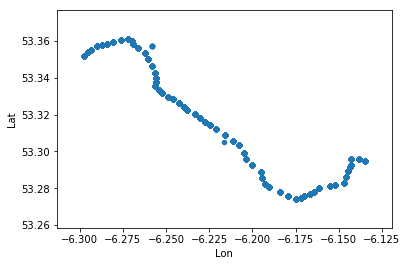

In [29]:
plotdf = schedule[(schedule.LineID == "46A") & (schedule.JourneyPatternID == 1)][["Lon", "Lat"]]
plotdf.plot.scatter(x="Lon", y="Lat")